# Lab 02 - Road Lines and Street Signs Detection with the Hough Transform

Computer Vision 2023-24 (M. Caligiuri, F. Lincetto, P. Zanuttigh)

In this lab you will explore the topic of line and circle detection using the Hough transform. In particular you will use this technique to segment the street lanes and the round street signs from the provided images.

---

## Import the necessary libraries

In [33]:
# Import the necessary packages
%matplotlib inline

import typing as tp
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from pathlib import Path

---

## Define some auxiliary functions

Write here all the auxiliary functions you will need.
More precisely the following functions are provided:
- `show_img` -> given in input an image and optionally a title it will plot the image as a matplotlib plot performing also the necessary conversion from BGR to RGB,
- `polar2cartesian` -> given an array of angles and one of radius it will return the corresponding cartesian coordinates as numpy arrays,
- `draw_lines` -> given in input an image and a set of lines it will draw the lines on the image and return the resulting image,
- `fill_lines` -> given in input an image and the mask of the lines it will fill the lines with a given color and return the resulting image,
- `check_param` -> given a list of value in imput check that none of them is less or equal to 0, returns a list containing the same values apart from the negative ones that will be set to 1.

In [34]:
# Function to plot images inline in the notebook
def show_img(img, title=None):
    #Check if the image is in BGR format and convert it to RGB
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    #Plot the image
    plt.figure(figsize=(10,5)) 
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close()

In [35]:
# Function to perform the conversion between polar and cartesian coordinates
def polar2cartesian(radius: np.ndarray, angle: np.ndarray, cv2_setup: bool = True) -> np.ndarray:
    if cv2_setup:
        return radius * np.array([np.cos(angle), np.sin(angle)])
    else:
        return radius * np.array([np.sin(angle), np.cos(angle)])

In [36]:
#Funtion to add lines to an image
def draw_lines(img: np.ndarray, lines: np.ndarray, color: tp.List[int] = [0, 0, 255], thickness: int = 1, cv2_setup: bool = True) -> tp.Tuple[np.ndarray]:
    new_image = np.copy(img)
    empty_image = np.zeros(img.shape[:2])

    if len(lines.shape) == 1:
        lines = lines[None, ...]

    # Draw found lines
    for rho, theta in lines:
        x0 = polar2cartesian(rho, theta, cv2_setup)
        direction = np.array([x0[1], -x0[0]])
        pt1 = np.round(x0 + 1000*direction).astype(int)
        pt2 = np.round(x0 - 1000*direction).astype(int)
        empty_image = cv.line(img=empty_image,pt1=pt1, pt2=pt2, color=255, thickness=thickness)

    # Keep lower part of each line until intersection
    mask_lines = empty_image != 0
    min_diff = np.inf
    max_line = 0
    for i in range(mask_lines.shape[0]):
        line = mask_lines[i]
        indices = np.argwhere(line)
        if indices[-1] - indices[0] < min_diff:
            min_diff = indices[-1] - indices[0]
            max_line = i

    mask_boundaries = np.zeros_like(empty_image)
    mask_boundaries[max_line:] = 1
    mask = (mask_lines * mask_boundaries).astype(bool)

    new_image[mask] = np.array(color)
    
    return new_image, mask

In [37]:
# Function that given the image and the mask of the lines, fill the area between the lines
def fill_lines(img: np.ndarray, mask: np.ndarray, color: tp.List[int] = [0, 0, 255]) -> np.ndarray:
    border = np.where(mask)

    possible_vertex = np.where(border[0] == np.min(border[0]))
    vertex = np.array([border[0][int(len(possible_vertex[0]) / 2)], border[1][int(len(possible_vertex[0]) / 2)]])[::-1]

    possible_bottom = np.where(border[0] == np.max(border[0]))
    bottom_pos = [np.min(possible_bottom[0]), np.max(possible_bottom[0])]
    bottom_left = np.array([border[0][bottom_pos[0]], border[1][bottom_pos[0]]])[::-1]
    bottom_right = np.array([border[0][bottom_pos[1]], border[1][bottom_pos[1]]])[::-1]
    points = np.array([vertex, bottom_left, bottom_right])

    return cv.fillConvexPoly(np.copy(img), points=points, color=color)

In [38]:
check_params = lambda x: [i if i > 0 else 1 for i in x]

---

## Road lines Detection

In this section you have to implement the road detection using the Hough transform together with the Canny algorithm.

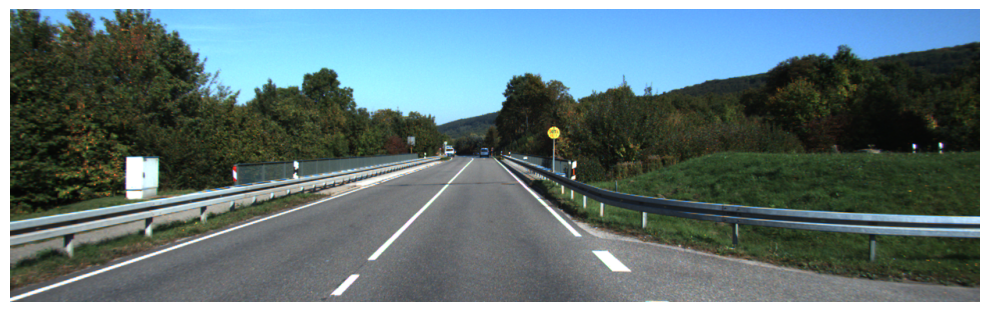

In [39]:
# Load image (img path './data/road2.png')
image_folder = Path('./data')
image_name = 'road2.png'
image_path = image_folder / image_name
# Open the image
image = cv.imread(str(image_path))

grey_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY);
# Show the image
# Suggestion: to show the image inline use the function show_img()
show_img(image)

### Edge extraction using the Canny algorithm

In [40]:
#Create a cv window with two trackbars to change the thresholds values of the Canny algorithm
# Using the trackbars choose the best thresholds values to extract the edges of the road
# Print also the best parameters
win_name = 'CannyParameters'

cv.namedWindow(win_name)
max_th = 1000

class CannyFilter:
    def __init__(self, tl, th):
        self.th = th
        self.tl = tl
        
    def set_th(self, val):
        #if self.th >= self.tl:
        self.th = val
        
    def set_tl(self, val):
        #if self.tl <= self.th:
        self.tl = val
    
    def get_th(self):
        return self.th
    
    def get_tl(self):
        return self.tl
    
    def __call__(self, image, tl: float, th: float):
        self.set_th(th)
        self.set_tl(tl)
        return cv.Canny(image, self.get_tl(), self.get_th(), 4)
        
filter = CannyFilter(600, 900)
canny_edges = filter(grey_image, filter.get_tl(), filter.get_th())

cv.createTrackbar('threshold_1', win_name, filter.get_tl(), max_th, lambda x: cv.imshow(win_name,filter(grey_image, x, filter.get_th())))
cv.createTrackbar('threshold_2', win_name, filter.get_th(), max_th, lambda x: cv.imshow(win_name, filter(grey_image, filter.get_tl(), x)))

cv.imshow(win_name, canny_edges)
cv.waitKey(0)
cv.destroyAllWindows()

In [41]:
best_tl = 634
best_th = 854
print(f'tl={best_tl}, th={best_th}')

tl=634, th=854


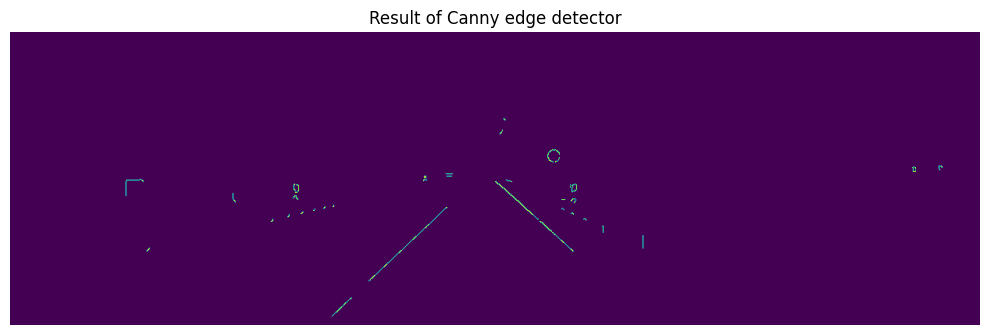

In [42]:
#Visualize the result of the Canny algorithm with the best thresholds values
# Suggestions: use the function show_img() and check that the edges are suitable for the next step (see the example on the slides)

best_canny_res = cv.Canny(grey_image, best_tl, best_th, 7)
show_img(best_canny_res, 'Result of Canny edge detector')

### Hough transform to detect lines

In [43]:
# Create a window with a set of trackbars to change the parameters of the Hough transform
# Using the trackbars choose the best parameters to find the lines of the road
win_name = 'Hough_transform'

theta = np.pi/180
rho = 1
threshold = 100
min_theta = 0
max_theta = np.pi

hough_params = [rho, theta, threshold, min_theta, max_theta]

cv.namedWindow(win_name)

def updateParam(val, index):
    if index != 2 and index != 0:
        hough_params[index] = val / 1000.
    else:
        hough_params[index] = val
       
    lines = cv.HoughLines(best_canny_res, hough_params[0], hough_params[1], hough_params[2], None, 0, 0, hough_params[3], hough_params[4])

    if lines is not None:
        lines = np.squeeze(lines, axis=1)
        result, _ = draw_lines(image, lines)
        cv.imshow(win_name, result)
        

cv.createTrackbar('rho', win_name, int(hough_params[0] * 10), 20, lambda x: updateParam(x, 0))
cv.createTrackbar('theta * 100', win_name, int(hough_params[1] * 1000), int(np.pi * 1000), lambda x: updateParam(x, 1))
cv.createTrackbar('threshold', win_name, hough_params[2], 200, lambda x: updateParam(x, 2))
cv.createTrackbar('min_theta * 100', win_name, int(hough_params[3] * 1000), int(np.pi * 1000), lambda x: updateParam(x, 3))
cv.createTrackbar('max_theta * 100', win_name, int(hough_params[4] * 1000), int(np.pi * 1000), lambda x: updateParam(x, 4))

cv.imshow(win_name, image)
cv.waitKey(0)
cv.destroyAllWindows()

print(hough_params)

[10, 0.017, 100, 0, 3.141]


[[[ 549.       0.783]]

 [[-306.       2.349]]]


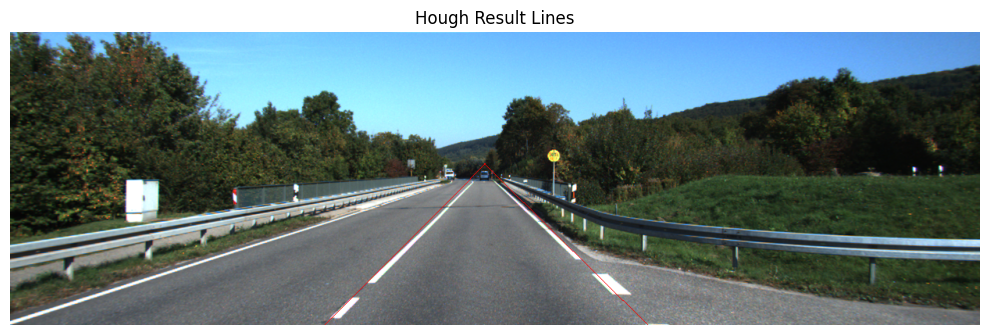

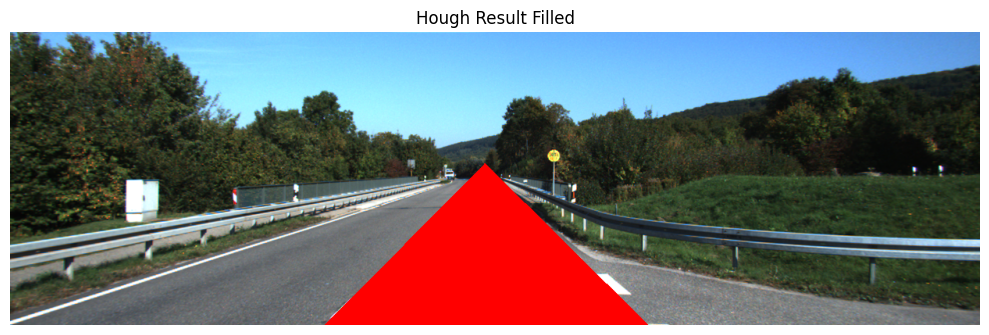

In [44]:
# Visualize the result of the Hough transform with the best parameters
rho = 9
theta = 0.261
threshold = 101
min_theta = 0
max_theta = np.pi

lines = cv.HoughLines(best_canny_res, rho, theta, threshold, None, 0, 0)
print(lines)
lines = np.squeeze(lines, axis=1)

result, mask = draw_lines(image, lines)

show_img(result, 'Hough Result Lines')

# Color all the pixel inside the lines in red (you can use the provided fill_lines function)
filled_image = fill_lines(result, mask)

show_img(filled_image, 'Hough Result Filled')

### Custom implementation of the Hough Transform

Now try to implement the Hough transform by yourself. You can use the following steps as a guide:
1. Define the discretization of the parameter space (i.e. the accumulator) and initialize the accumulator matrix to zero,
2. For each edge point in the image:
    - For each angle in the discretization:
        1. Compute the corresponding radius,
        2. Increment the accumulator at the corresponding position,
3. Find the largest values in the accumulator,
4. Get the corresponding angle and radius,
5. Return the line corresponding to the angle and radius.

In [45]:
rho = 9
theta = 0.261
threshold = 101

# Define a function to perform the Hough transform and return the lines found
def hough_lines(edges: np.ndarray, threshold: float, min_theta: float, max_theta: float) -> np.ndarray:
    # Initialize the counter matrix in polar coordinates
    diagonal = np.sqrt(image.shape[0]**2 + image.shape[1]**2)
    
    # Compute the values for the thetas and the rhos
    theta_angles = np.arange(min_theta, max_theta, theta)
    rho_values = np.arange(-diagonal, diagonal, rho)
    # Compute the dimension of the accumulator matrix
    num_thetas = len(theta_angles)
    num_rhos = len(rho_values)
    accumulator = np.zeros([num_rhos, num_thetas])
    print('Accumulator shape (rhos x thetas):' + str(accumulator.shape))

    # Pre-compute sin and cos
    sins = np.sin(theta_angles)
    coss = np.cos(theta_angles)
    
    # Consider edges only
    xs, ys = np.where(edges > 0)
    
    for x,y in zip(xs,ys):
        for t in range(num_thetas):
            # compute the rhos for the given point for each theta
            current_rho = x * coss[t] + y * sins[t]
            # for each rho, compute the closest rho among the rho_values below it
            # the index corresponding to that rho is the one we will increase
            rho_pos = np.where(current_rho > rho_values)[0][-1]
            #rho_pos = np.argmin(np.abs(current_rho - rho_values))
            accumulator[rho_pos, t] += 1
    
    print(f'Accumulator matrix at the end', accumulator)
    # Take the polar coordinates most matched
    final_rho_index, final_theta_index = np.where(accumulator > threshold)
    final_rho = rho_values[final_rho_index]    
    final_theta = theta_angles[final_theta_index]
    
    polar_coordinates = np.vstack([final_rho, final_theta]).T
    
    #neg_coord = np.where(polar_coordinates[:,1] < 0)[0]
    #polar_coordinates[neg_coord, 1] = polar_coordinates[neg_coord, 1] + np.pi
    #polar_coordinates[neg_coord, 0] = -polar_coordinates[neg_coord, 0]
    print('Final polar coordinates shape', polar_coordinates.shape)
    print('Final polar coordinates\n', polar_coordinates)
    
    return polar_coordinates


Accumulator shape (rhos x thetas):(289, 13)
Accumulator matrix at the end [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Final polar coordinates shape (2, 2)
Final polar coordinates
 [[-316.3777399    -0.78779633]
 [ 547.6222601     0.77820367]]


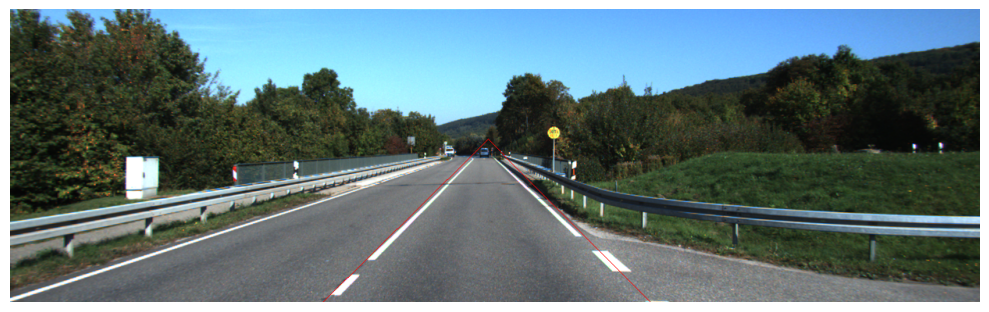

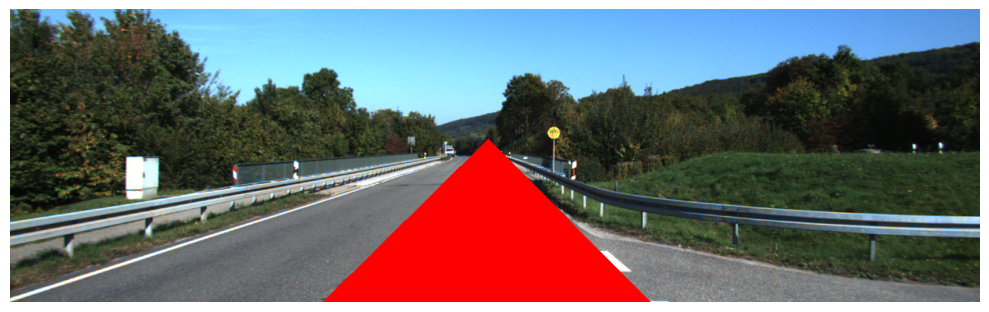

In [46]:
# Use the function to find the lines in the image
lines = hough_lines(best_canny_res, threshold, -np.pi/2, np.pi/2)

# Show the image with the lines found
# Suggestions: use the function fill_lines() and show_img()
lines_img, mask = draw_lines(image, lines, cv2_setup=False)
show_img(lines_img)

masked_img = fill_lines(lines_img, mask)
show_img(masked_img)

---

835## Road signs detection using the Hough transform

In this section you will implement the road signs detection using again the Hough transform.

**N.B.** You can use the `cv.HoughCircles()` function (keep in mind that this function includes the edge extraction). Here no need to implement the Hough transform manually, just use openCV in this point.

**N.B.** You can use the `cv.circle()` function to draw the circles on the image (set thickness = -1 to fill the circles).

In [47]:
# Convert the image to uint8 for the Hough transform algorithm
#image = image.astype(np.uint8)
#grey_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

hough_circle_params = [1.3, 30, 20, 4, 15]

win_name = 'hough_circles'

def update_circle_param(val, index):
    scratch_img = image.astype(np.uint8)
    if index != 0:
        hough_circle_params[index] = val
    else:
        hough_circle_params[index] = val / 10.
    
    circles = cv.HoughCircles(grey_image, cv.HOUGH_GRADIENT, hough_circle_params[0], hough_circle_params[1], param1=best_th, param2=hough_circle_params[2], minRadius=hough_circle_params[3], maxRadius=hough_circle_params[4])
    
    if circles is not None:
        # Convert circle coordinates to integers
        circles = circles.astype(np.int32)
        # Plot the circles over the scratch image we just created
        for c in circles[0, :]:
            cv.circle(scratch_img, (c[0], c[1]), c[2], (0,255,0), -1)
        cv.imshow(win_name, scratch_img)

# Create a window with a set of trackbars to change the parameters of the Hough transform
# Using the trackbars choose the best parameters to find all the circle sign in the image
cv.namedWindow(win_name)
cv.createTrackbar('dp', win_name, int(hough_circle_params[0] * 10), 30, lambda x: update_circle_param(x, 0))
cv.createTrackbar('minDist', win_name, hough_circle_params[1], 50, lambda x: update_circle_param(x, 1))
cv.createTrackbar('threshold', win_name, hough_circle_params[2], 80, lambda x: update_circle_param(x, 2))
cv.createTrackbar('minRadius', win_name, hough_circle_params[3], 50, lambda x: update_circle_param(x, 3))
cv.createTrackbar('maxRadius', win_name, hough_circle_params[4], 50, lambda x: update_circle_param(x, 4))

cv.imshow(win_name, image)
cv.waitKey(0)
cv.destroyAllWindows()

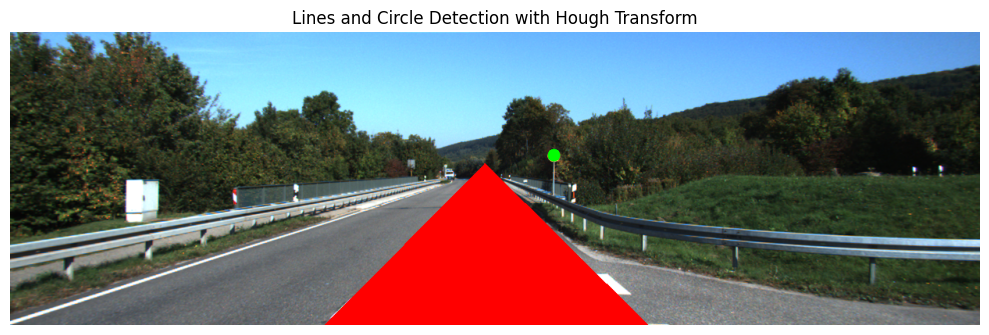

In [48]:
# Visualize the result of the Hough transform with the best parameters
best_circle_params = [1.3, 30, 20, 4, 15]

scratch_img = filled_image.astype(np.uint8)

circles = cv.HoughCircles(grey_image, cv.HOUGH_GRADIENT, hough_circle_params[0], hough_circle_params[1], param1=best_th, param2=hough_circle_params[2], minRadius=hough_circle_params[3], maxRadius=hough_circle_params[4])

if circles is not None:
    circles = circles.astype(np.int32)
    for c in circles[0, :]:
        cv.circle(scratch_img, (c[0], c[1]), c[2], (0,255,0), -1)
        
show_img(scratch_img, 'Lines and Circle Detection with Hough Transform')